<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/K_Nearest_Neighbours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTING THE LIBRARIES 

In [0]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

** Mounting from google drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## FEATURIZATION 1 : TFIDF = WORD2VEC

In [0]:
tfw2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Train_TFW2V.sav','rb'))

In [0]:
tfw2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Test_TFW2V.sav','rb'))

____

Creating the Train and Test set respectively for training KNN and Crossvalidation

____


In [0]:
X_train = tfw2v_train.iloc[:,0:50]
y_train = tfw2v_train['Score']
X_test = tfw2v_test.iloc[:,0:50]
y_test = tfw2v_test['Score']

** STANDARD SCALING THE DATA **

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

** CROSS VALIDATION : FINIDING OPTIMAL K : NEAREST NEIGHBOURS FOR TFIDF WORD2VEC **

In [66]:
cv = dict()

for i in range(1,12,2):
  knn = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree',n_jobs = -1)
  results = cross_val_score(knn,X_train,y_train,cv=10,n_jobs = -1,scoring = 'accuracy')
  results = results * 100
  cv[i] = np.mean(results)
  print("For K = " + str(i) + " Accuracy = " + str(np.mean(results)))

For K = 1 Accuracy = 85.05713314311933
For K = 3 Accuracy = 88.1199845952475
For K = 5 Accuracy = 89.06142439970837
For K = 7 Accuracy = 89.34142827932945
For K = 9 Accuracy = 89.45142766810494
For K = 11 Accuracy = 89.56285481215738


Text(0,0.5,' Accuracy ')

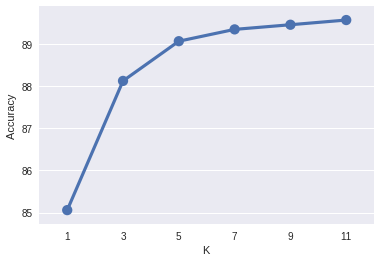

In [67]:
sns.pointplot(x = list(range(1,12,2)),y= list(cv.values()))
plt.xlabel(" K ")
plt.ylabel(" Accuracy ")

----------

The maximum accuracy is given by ** K = 11 **

1. Training the whole train on K = 11
2. Predicting for X_test 
3. Reporting the accuracy 
------


In [0]:
knn = KNeighborsClassifier(n_neighbors = 11,algorithm='kd_tree',n_jobs = -1)

In [69]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')

In [0]:
pred = knn.predict(X_test)

In [80]:
print("TEST ACCURACY : "+str(accuracy_score(y_test,pred) * 100))

TEST ACCURACY : 87.98333333333333


In [81]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.69      0.22      0.33      4101
          1       0.89      0.98      0.93     25899

avg / total       0.86      0.88      0.85     30000




------------

## FEATURIZATION 2 : AVERAGE WORD2VEC
_____


In [0]:
w2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_train.sav','rb'))
w2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_test.sav','rb'))

In [0]:
X_train = w2v_train.iloc[:,0:50]
y_train = w2v_train['Score']
X_test = w2v_test.iloc[:,0:50]
y_test = w2v_test['Score']

** STANDARAD SCALING THE DATA**

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

** CROSS VALIDATION : FINIDING OPTIMAL K : NEAREST NEIGHBOURS FOR BAG OF WORDS**

In [82]:
cv = dict()

for i in range(1,12,2):
  knn = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree',n_jobs = -1)
  results = cross_val_score(knn,X_train,y_train,cv=10,n_jobs = -1,scoring = 'accuracy')
  results = results * 100
  cv[i] = np.mean(results)
  print("For K = " + str(i) + " Accuracy = " + str(np.mean(results)))

For K = 1 Accuracy = 86.41139396994099
For K = 3 Accuracy = 88.95142378760923
For K = 5 Accuracy = 89.584277670408
For K = 7 Accuracy = 89.81999154900856
For K = 9 Accuracy = 89.95285522346936
For K = 11 Accuracy = 89.99999277524766


Text(0,0.5,' Accuracy ')

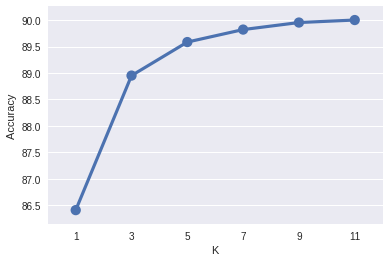

In [88]:
sns.pointplot(x = list(range(1,12,2)),y= list(cv.values()))
plt.xlabel(" K ")
plt.ylabel(" Accuracy ")

In [0]:
knn = KNeighborsClassifier(n_neighbors = 11,algorithm='kd_tree',n_jobs = -1)

In [84]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')

In [0]:
pred = knn.predict(X_test)

In [86]:
print("TEST ACCURACY : "+str(accuracy_score(y_test,pred) * 100))

TEST ACCURACY : 88.52333333333333


In [87]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.73      0.26      0.38      4101
          1       0.89      0.98      0.94     25899

avg / total       0.87      0.89      0.86     30000



------------

## FEATURIZATION 3 : BOW
_____